# Alpamayo-R1 Demo

In [15]:
import os
os.environ["HF_HOME"] = "/workspace/hf"
os.environ["TRANSFORMERS_CACHE"] = "/workspace/hf/transformers"
os.environ["HF_DATASETS_CACHE"] = "/workspace/hf/datasets"
os.environ["UV_CACHE_DIR"] = "/workspace/.cache/uv"

In [16]:
import sys
print(sys.executable)

/workspace/alpamayo/ar1_venv/bin/python


This notebook will load some example data from the NVIDIA [PhysicalAI-AV Dataset](https://huggingface.co/datasets/nvidia/PhysicalAI-Autonomous-Vehicles) and run the Alpamayo-R1 model on it, producing and visualizing output trajectories and associated reasoning traces.

In [17]:
import copy
import numpy as np
import mediapy as mp
import pandas as pd

import torch
from alpamayo_r1.models.alpamayo_r1 import AlpamayoR1
from alpamayo_r1.load_physical_aiavdataset import load_physical_aiavdataset
from alpamayo_r1 import helper

### Load model and construct data preprocessor

In [18]:
model = AlpamayoR1.from_pretrained("nvidia/Alpamayo-R1-10B", dtype=torch.bfloat16).to("cuda")
processor = helper.get_processor(model.tokenizer)

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.19 GiB. GPU 0 has a total capacity of 23.54 GiB of which 1.03 GiB is free. Process 3644121 has 22.50 GiB memory in use. Of the allocated memory 21.75 GiB is allocated by PyTorch, and 263.81 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

### Load and prepare data

In [ ]:
import sys
import os
sys.path.append(os.path.abspath("../scripts"))
from convert_rosbag import process_bag

# Define paths
# input_bag = "../rosbag2_autoware/rosbag2_autoware_0.mcap"
# Assuming the user wants to use the same bag or specified one. 
# Using relative path from notebooks dir
input_bag = "../rosbag2_autoware/rosbag2_autoware_0.mcap"
output_pt = "processed_data_01082.pt"

print(f"Processing {input_bag}...")
# Run conversion
# Define t0_ns to sample from the middle of the bag (50%) to avoid end-of-bag oddities
# Timestamp determined from verification (1767893206238777600)
t0_ns = 1767893206238777600 
process_bag(input_bag, output_pt, t0_ns=t0_ns)

# Load processed data
print(f"Loading {output_pt}...")
data = torch.load(output_pt, weights_only=False)
print("Loaded data keys:", data.keys())

if data["tokenized_data"] is not None:
    model_inputs = {
        "tokenized_data": data["tokenized_data"],
        "ego_history_xyz": data["ego_history_xyz"],
        "ego_history_rot": data["ego_history_rot"],
    }
    model_inputs = helper.to_device(model_inputs, "cuda")
else:
    print("Warning: tokenized_data is None. Running tokenization...")
    messages = helper.create_message(data["image_frames"].flatten(0, 1))
    inputs = processor.apply_chat_template(
        messages,
        tokenize=True,
        add_generation_prompt=False,
        continue_final_message=True,
        return_dict=True,
        return_tensors="pt",
    )
    model_inputs = {
        "tokenized_data": inputs,
        "ego_history_xyz": data["ego_history_xyz"],
        "ego_history_rot": data["ego_history_rot"],
    }
    model_inputs = helper.to_device(model_inputs, "cuda")

# Visualize images
if "image_frames" in data:
    # data['image_frames'] shape: (N_cameras, T, 3, H, W)
    # flatten cameras and time -> (N*T, 3, H, W)
    # permute for display -> (N*T, H, W, 3)
    images_to_show = data["image_frames"].flatten(0, 1).permute(0, 2, 3, 1)
    mp.show_images(images_to_show, columns=4, width=200)
else:
    print("No image frames found in loaded data.")


### Model inference

In [ ]:
torch.cuda.manual_seed_all(42)
with torch.autocast("cuda", dtype=torch.bfloat16):
    pred_xyz, pred_rot, extra = model.sample_trajectories_from_data_with_vlm_rollout(
        data=copy.deepcopy(model_inputs),
        top_p=0.98,
        temperature=0.6,
        num_traj_samples=1,  # Feel free to raise this for more output trajectories and CoC traces.
        max_generation_length=256,
        return_extra=True,
    )

# the size is [batch_size, num_traj_sets, num_traj_samples]
print("Chain-of-Causation (per trajectory):\n", extra["cot"][0])

Chain-of-Causation (per trajectory):
 [['Nudge to the left to increase clearance from the construction cones encroaching into the lane.']]


## Visualizing data and results

,,,
,,,
,,,
,,,

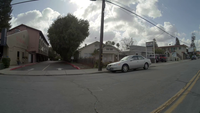
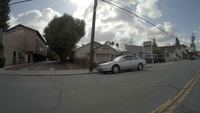
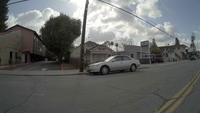
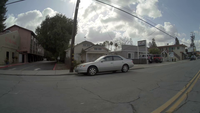
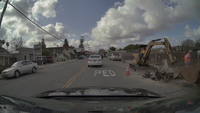
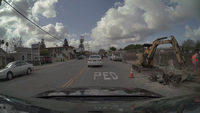
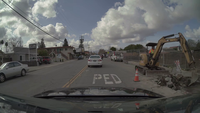
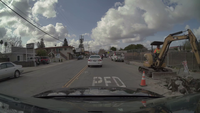
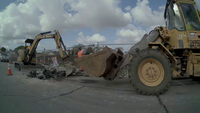
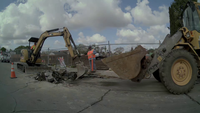
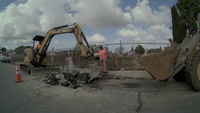
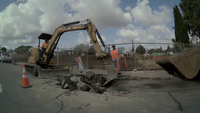
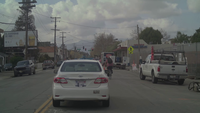
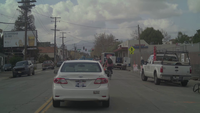
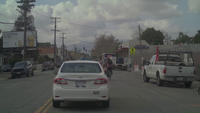
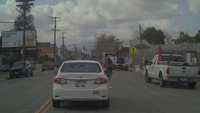

In [ ]:
mp.show_images(data["image_frames"].flatten(0, 1).permute(0, 2, 3, 1), columns=4, width=200)

(np.float64(-0.024506468944309745),
 np.float64(0.5200872146597249),
 np.float64(-3.015261682868004),
 np.float64(83.31762418448925))

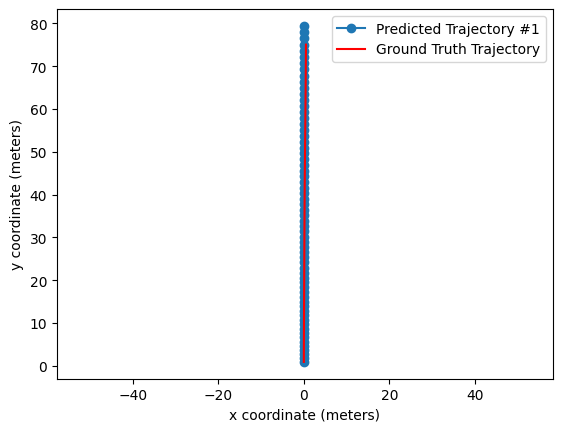

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
def rotate_90cc(xy):
    # Rotate (x, y) by 90 deg CCW -> (y, -x)
    return np.stack([-xy[1], xy[0]], axis=0)

for i in range(pred_xyz.shape[2]):
    pred_xy = pred_xyz.cpu()[0, 0, i, :, :2].T.numpy()
    pred_xy_rot = rotate_90cc(pred_xy)
    plt.plot(*pred_xy_rot, "o-", label=f"Predicted Trajectory #{i + 1}")

if "ego_future_xyz" in data:
    gt_xy = data["ego_future_xyz"].cpu()[0, 0, :, :2].T.numpy()
    gt_xy_rot = rotate_90cc(gt_xy)
    plt.plot(*gt_xy_rot, "r-", label="Ground Truth Trajectory")
else:
    print("No ground truth trajectory to plot.")

plt.ylabel("y coordinate (meters)")
plt.xlabel("x coordinate (meters)")
plt.legend(loc="best")
plt.axis("equal")


In [ ]:
if "ego_future_xyz" in data:
    pred_xy = pred_xyz.cpu().numpy()[0, 0, :, :, :2].transpose(0, 2, 1)
    diff = np.linalg.norm(pred_xy - gt_xy[None, ...], axis=1).mean(-1)
    print("minADE:", diff.min(), "meters")
else:
    print("Skipping minADE calculation (no ground truth).")


minADE: 1.629812 meters


In [ ]:
# --- Lanelet2 Map Visualization ---
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import numpy as np

def parse_osm_map(osm_path):
    tree = ET.parse(osm_path)
    root = tree.getroot()
    
    nodes = {}
    for node in root.findall('node'):
        id = node.get('id')
        tags = {tag.get('k'): tag.get('v') for tag in node.findall('tag')}
        if 'local_x' in tags and 'local_y' in tags:
            nodes[id] = (float(tags['local_x']), float(tags['local_y']))
            
    ways = []
    for way in root.findall('way'):
        nds = [nd.get('ref') for nd in way.findall('nd')]
        # Filter nodes that have coordinates
        coords = [nodes[ref] for ref in nds if ref in nodes]
        if len(coords) > 1:
            ways.append(coords)
    return nodes, ways

def transform_to_global(pred_local, t0_pos, t0_Rot):
    # pred_local: (T, 2) or (T, 3)
    # t0_pos: (3,)
    # t0_Rot: (3, 3)
    
    # Global = t0_pos + t0_Rot * local
    # We only care about xy mostly, but let's do full 3d mult if inputs are 3d
    
    if pred_local.shape[-1] == 2:
        # Pad z=0
        zeros = np.zeros((pred_local.shape[0], 1))
        pred_local_3d = np.hstack([pred_local, zeros])
    else:
        pred_local_3d = pred_local
        
    pred_global = t0_pos + (t0_Rot @ pred_local_3d.T).T
    return pred_global[:, :2]

map_path = "../lanelet2_map.osm"
if os.path.exists(map_path):
    print(f"Loading map from {map_path}...")
    nodes, ways = parse_osm_map(map_path)
    
    plt.figure(figsize=(12, 12))
    
    # Plot Map
    for way in ways:
        way = np.array(way)
        plt.plot(way[:, 0], way[:, 1], 'k-', linewidth=0.5, alpha=0.5)
        
    # Validation: Transform GT if available ? No GT future usually.
    # But we have t0_pos (current pos).
    
    if "t0_pos" in data and "t0_Rot" in data:
        t0_pos = data["t0_pos"]
        t0_Rot = data["t0_Rot"]
        
        # Plot Ego Start
        plt.plot(t0_pos[0], t0_pos[1], 'ro', label="Ego Start", markersize=10)
        
        # Transform and Plot Predictions
        # pred_xyz is (B, num_samples, T, 3) -> we took sample i
        # Access the pred_xyz from previous cell logic if available, or re-access ?
        # The 'pred_xyz' var might be available from previous cell execution context.
        # But safest to re-extract from tensor if needed.
        # The previous viz loop iterated 'i'. We can just plot all samples here or the last one.
        
        # Let's assume we want to plot all samples generated.
        num_samples = pred_xyz.shape[2]
        for i in range(num_samples):
            # pred_xyz shape: [1, 1, num_samples, T, 3] ? No [1, 1, num_samples, T, 2]? 
            # Looking at previous code: pred_xyz.cpu()[0, 0, i, :, :2]
            
            # The model output 'pred_xyz' is usually (B, sets, samples, T, 3)
            # Notebook said: pred_xyz.cpu()[0, 0, i, :, :2]
            
            local_traj = pred_xyz.cpu().numpy()[0, 0, i, :, :3] # Take 3D
            global_traj = transform_to_global(local_traj, t0_pos, t0_Rot)
            
            plt.plot(global_traj[:, 0], global_traj[:, 1], 'b-', linewidth=2, label=f"Pred #{i+1}" if i==0 else None)
            
    else:
        print("Global pose (t0_pos/t0_Rot) not found in data. Re-run data processing.")

    plt.axis("equal")
    plt.title("Global Trajectory on Lanelet2 Map")
    plt.legend()
    plt.show()
else:
    print(f"Map file not found: {map_path}")
